In [1]:
import sys

sys.path.insert(0, '/Users/egork/.pyenv/versions/3.6.7/lib/python3.6/site-packages/')
%matplotlib inline

from scipy.io import loadmat
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
import time
from sklearn.preprocessing import minmax_scale
from random import sample
from random import seed
from sklearn.preprocessing import minmax_scale, LabelEncoder
from sklearn.utils.multiclass import type_of_target
epsilon = 10**(-8)

In [2]:
import glob
data_files = glob.glob('./data/*.mat')
print(data_files)

['./data/pima.mat', './data/arrhythmia.mat', './data/shuttle.mat', './data/thyroid.mat', './data/breastw.mat', './data/satellite.mat', './data/annthyroid.mat', './data/ionosphere.mat', './data/smtp.mat', './data/mammography.mat']


In [3]:
def read_data(file_name):
    print(file_name)
    data = loadmat(file_name)
    return data['X'], data['y']

In [4]:
file_name = './data/satellite.mat'
x={}
features, label = read_data(file_name)

./data/satellite.mat


In [5]:
features.shape[0]*0.04

257.4

In [6]:
min_leaf_size, n_trees = 257, 500

In [7]:
forest_parameters = dict(n_estimators=n_trees, criterion='mae', max_features=0.333333,
                        oob_score=True, verbose=1, n_jobs=-1,  min_samples_leaf=min_leaf_size)

In [8]:
print(pd.DataFrame(features).nunique().values)
print(pd.DataFrame(features).nunique().values/features.shape[0])

[ 51  84  76 102  51  82  76 103  50  81  78 104  51  83  78 101  50  80
  77 104  50  80  78 104  51  82  75 102  50  81  77 103  50  80  77 104]
[0.00792541 0.01305361 0.01181041 0.01585082 0.00792541 0.01274281
 0.01181041 0.01600622 0.00777001 0.01258741 0.01212121 0.01616162
 0.00792541 0.01289821 0.01212121 0.01569542 0.00777001 0.01243201
 0.01196581 0.01616162 0.00777001 0.01243201 0.01212121 0.01616162
 0.00792541 0.01274281 0.01165501 0.01585082 0.00777001 0.01258741
 0.01196581 0.01600622 0.00777001 0.01243201 0.01196581 0.01616162]


In [9]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import explained_variance_score

def _set_oob_error(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]
        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx])
    return np.array([np.sum(((values - y[idx])**2)/len(values)) for idx, values in enumerate(predictions)])


def _set_oob_variance(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]

        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx].tolist()[0])
    return np.array([np.var(arr) for arr in predictions])


def compute_metric_single_feature(features, feature_index):
    print("Continious appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()

    regressor=RandomForestRegressor(**forest_parameters)
    
    
    y=features[:, feature_index]    
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    regressor.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))


    predictions = regressor.oob_prediction_
    
    results_pd['prediction_{}'.format(feature_index)] = pd.Series(np.array(predictions)[:])
    np_log=np.log(np.abs((np.array(predictions)[:]+epsilon)/(y+epsilon)))
    abs_diff = np.abs(np.array(predictions)[:] - y) + epsilon
    results_pd['abs_diff_{}'.format(feature_index)] = pd.Series(abs_diff)
    results_pd['abs_diff_min_max_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(abs_diff, feature_range=(epsilon, 1)))

    results_pd['abs_diff_median_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(_set_oob_error(regressor.estimators_, np.array(train, dtype=np.float32), y)))
    results_pd['log_ratio_{}'.format(feature_index)] = pd.Series(np_log)
    results_pd['log_abs_ratio_{}'.format(feature_index)] = pd.Series(np.abs(np_log))
    feature_imp = np.insert(regressor.feature_importances_, feature_index, 0,axis=0)
    weight = 1 - min(1, (1 - metrics.r2_score(y, np.array(predictions)[:],
                                              multioutput='raw_values'))**0.5)
    print("Weight: {}".format(weight))
    results_pd['weighted_abs_diff_median_scaling_{}'.format(feature_index)] =  weight * pd.Series(abs_diff/(np.median(abs_diff)+epsilon))
    return results_pd

def compute_metrics_single_categorical_feature(features, feature_index, bin_number=None):
    print("Categorical appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()
    classifier = RandomForestClassifier(oob_score=True, 
                                        n_estimators=n_trees, bootstrap=True, n_jobs=-1,
                                        criterion='entropy', min_samples_leaf=min_leaf_size, verbose=1)

    y=features[:, feature_index]
    if bin_number or type_of_target(features[:, feature_index])=='continuous':
        if bin_number:
            bins = min(np.unique(y).shape[0], bin_number)
        else:
            bins = np.unique(y).shape[0]
        y = np.digitize(y, bins=np.histogram(y, bins=bins)[1])
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    
    classifier.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))

    y_map={value: list(set(y.flatten())).index(value)  for value in set(y.flatten())}

    probability_scores=[classifier.oob_decision_function_[index,:][y_map[element]] for index, element in enumerate(y.flatten())]
    
    entropy_list=[]
    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
    entropy_np = np.array([sum([-value*np.log(value+epsilon) for value in ls])/max_entropy + (1.0-probability_scores[idx]) for idx, ls in enumerate(classifier.oob_decision_function_)])
    results_pd["abs_diff_median_scaling_{}".format(feature_index)] = minmax_scale(pd.Series(entropy_np))
    return results_pd

In [10]:
## Average forest

results_all_features_pd = pd.DataFrame()
feature_weights=np.zeros(features.shape[1])
feature_weights_r2=[]
min_number_of_values = 300
num_feature_index = [feature_index for feature_index in range(features.shape[1])
                     if len(set(features[:, feature_index])) > 0]
bin_number = None
for feature_index in num_feature_index:
    print('--- feature index {} / {} ---'.format(feature_index, features.shape[1]-1))
    if len(set(features[:, feature_index])) > min_number_of_values:
        results_pd = compute_metric_single_feature(features, feature_index)
    else:
        results_pd = compute_metrics_single_categorical_feature(features, feature_index, bin_number)
 
    results_all_features_pd[results_pd.columns] = results_pd


--- feature index 0 / 35 ---
Categorical appraoch feature 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.3336501121520996 seconds fit ---
--- feature index 1 / 35 ---
Categorical appraoch feature 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished


--- 2.710739850997925 seconds fit ---
--- feature index 2 / 35 ---
Categorical appraoch feature 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.4327168464660645 seconds fit ---
--- feature index 3 / 35 ---
Categorical appraoch feature 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


--- 2.662024974822998 seconds fit ---
--- feature index 4 / 35 ---
Categorical appraoch feature 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.292550802230835 seconds fit ---
--- feature index 5 / 35 ---
Categorical appraoch feature 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.3194570541381836 seconds fit ---
--- feature index 6 / 35 ---
Categorical appraoch feature 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.254899024963379 seconds fit ---
--- feature index 7 / 35 ---
Categorical appraoch feature 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.499459743499756 seconds fit ---
--- feature index 8 / 35 ---
Categorical appraoch feature 8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.0721731185913086 seconds fit ---
--- feature index 9 / 35 ---
Categorical appraoch feature 9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.33254075050354 seconds fit ---
--- feature index 10 / 35 ---
Categorical appraoch feature 10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


--- 2.4086639881134033 seconds fit ---
--- feature index 11 / 35 ---
Categorical appraoch feature 11


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


--- 2.6272189617156982 seconds fit ---
--- feature index 12 / 35 ---
Categorical appraoch feature 12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.2059009075164795 seconds fit ---
--- feature index 13 / 35 ---
Categorical appraoch feature 13


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.2609059810638428 seconds fit ---
--- feature index 14 / 35 ---
Categorical appraoch feature 14


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.135031223297119 seconds fit ---
--- feature index 15 / 35 ---
Categorical appraoch feature 15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.3188138008117676 seconds fit ---
--- feature index 16 / 35 ---
Categorical appraoch feature 16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.936387062072754 seconds fit ---
--- feature index 17 / 35 ---
Categorical appraoch feature 17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.1313929557800293 seconds fit ---
--- feature index 18 / 35 ---
Categorical appraoch feature 18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.1315841674804688 seconds fit ---
--- feature index 19 / 35 ---
Categorical appraoch feature 19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.3066301345825195 seconds fit ---
--- feature index 20 / 35 ---
Categorical appraoch feature 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.9656989574432373 seconds fit ---
--- feature index 21 / 35 ---
Categorical appraoch feature 21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.133094072341919 seconds fit ---
--- feature index 22 / 35 ---
Categorical appraoch feature 22


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.1345608234405518 seconds fit ---
--- feature index 23 / 35 ---
Categorical appraoch feature 23


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.3090460300445557 seconds fit ---
--- feature index 24 / 35 ---
Categorical appraoch feature 24


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.0508759021759033 seconds fit ---
--- feature index 25 / 35 ---
Categorical appraoch feature 25


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.1724042892456055 seconds fit ---
--- feature index 26 / 35 ---
Categorical appraoch feature 26


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.12369704246521 seconds fit ---
--- feature index 27 / 35 ---
Categorical appraoch feature 27


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


--- 2.5655908584594727 seconds fit ---
--- feature index 28 / 35 ---
Categorical appraoch feature 28


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.9556150436401367 seconds fit ---
--- feature index 29 / 35 ---
Categorical appraoch feature 29


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.160965919494629 seconds fit ---
--- feature index 30 / 35 ---
Categorical appraoch feature 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.1752169132232666 seconds fit ---
--- feature index 31 / 35 ---
Categorical appraoch feature 31


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.345808267593384 seconds fit ---
--- feature index 32 / 35 ---
Categorical appraoch feature 32


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.9199559688568115 seconds fit ---
--- feature index 33 / 35 ---
Categorical appraoch feature 33


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.128535032272339 seconds fit ---
--- feature index 34 / 35 ---
Categorical appraoch feature 34


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.183671236038208 seconds fit ---
--- feature index 35 / 35 ---
Categorical appraoch feature 35


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 2.398820161819458 seconds fit ---


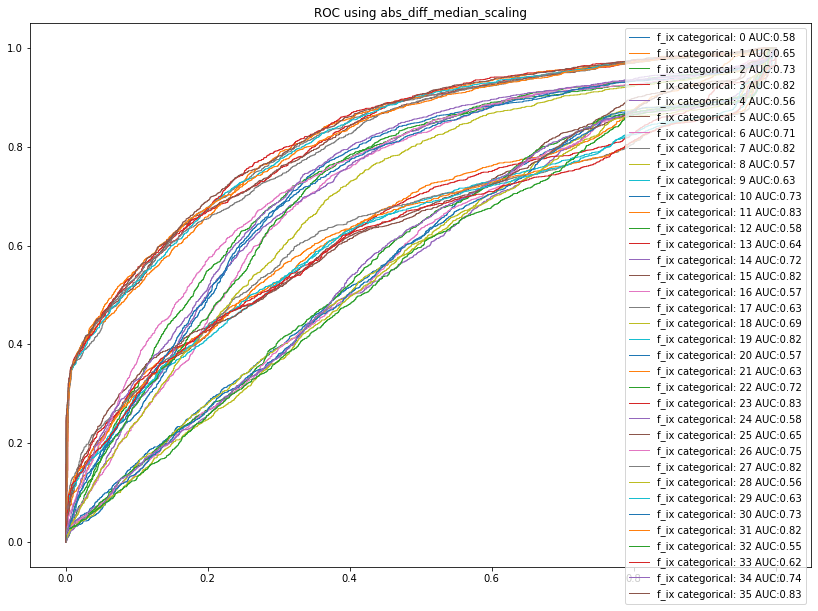

0.8326685918526759


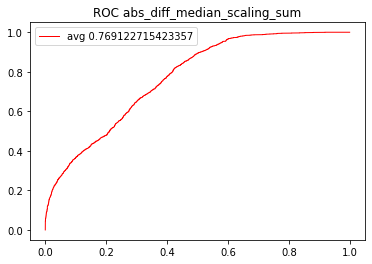

In [12]:
metric_name = 'abs_diff_median_scaling'
plt.figure(figsize=[14, 10])
auc=[]
columns_list_names=['{}_{}'.format(metric_name, feature_index) for feature_index in num_feature_index]

for feature_index in num_feature_index:
    fpr, tpr, thresholds = metrics.roc_curve(label.flatten(),
                                             results_all_features_pd['{}_{}'.format(metric_name, feature_index )],
                                             pos_label=1)
    if len(set(features[:, feature_index])) > min_number_of_values:
        message = "f_ix continious: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    else:
        message = "f_ix categorical: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    plt.plot(fpr, tpr, lw=1, label=message,
             color='C{}'.format(feature_index%10))
    plt.title("ROC using {}".format(metric_name))
    auc.append(metrics.auc(fpr, tpr))
plt.legend()
plt.show()
print(max(auc))

# simple sum
metric_sum =(results_all_features_pd[columns_list_names]).sum(axis=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(label.flatten(), metric_sum, pos_label=1)
plt.plot(fpr1, tpr1, color='red', lw=1, label='avg {}'.format(metrics.auc(fpr1, tpr1)))
plt.title("ROC {}_sum".format(metric_name))
plt.legend()
plt.show()